## Objetivo específico do trabalho: analisar a base construída com dados de jogos esportivos ao vivo e prever um evento específico e isolado por meio de automl e redes neurais com bons resultados

# Load and imports

In [78]:
import pandas as pd

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores_full.csv', encoding='utf-8')
print(df05ht.shape)

(1550723, 37)


In [79]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway',
       'shotsHome', 'shotsAway', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away',
       'fouls_won_home', 'fouls_won_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id'],
      dtype='object')

In [80]:
df05ht

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-09,90+4:21,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
1,2020-01-09,90+3:42,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
2,2020-01-09,90+3:02,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
3,2020-01-09,90+2:23,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
4,2020-01-09,90+1:44,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,12.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550718,2024-06-02,3:14,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550719,2024-06-02,2:34,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550720,2024-06-02,1:54,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550721,2024-06-02,1:14,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-06-02-Real Zaragoza-Albacete Balompié


In [81]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2024-06-02 00:00:00


In [82]:
df05ht.drop_duplicates(subset=df05ht.columns.difference(['match_id']), keep='last')

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-09,90+4:21,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
1,2020-01-09,90+3:42,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
2,2020-01-09,90+3:02,FC Barcelona,Club Atlético de Madrid,2.0,3.0,16.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
3,2020-01-09,90+2:23,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,13.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
4,2020-01-09,90+1:44,FC Barcelona,Club Atlético de Madrid,2.0,3.0,15.0,6.0,6.0,2.0,...,18.0,14.0,14.0,16.0,2.0,2.0,12.0,19.0,0,2020-01-09-FC Barcelona-Club Atlético de Madrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550718,2024-06-02,3:14,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550719,2024-06-02,2:34,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550720,2024-06-02,1:54,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550721,2024-06-02,1:14,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-06-02-Real Zaragoza-Albacete Balompié


# Analisando e tratando os dados

## Limpeza

In [83]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

Dimensão do DataFrame antes remoção: (1550723, 37)
Valores únicos de minutos antes da conversão: ['90+4:21' '90+3:42' '90+3:02' ... '90+14:52' '90+11:46' '10:57'] 

Registros duplicados: 70
Registros nulos: 53640



In [84]:
# apenas o primeiro tempo
df = df[df['minute'].str.match(r"^(45\+([0-9]|\d+):\d+|4[0-4]:\d+|[0-3]?[0-9]:\d+|45:([0-5][0-9]|\d))$")]

In [85]:


# Função para converter o formato de tempo para decimal
def convert_to_decimal(time_str):
    # Separar os minutos dos segundos
    if '+' in time_str:
        main_minutes, extra = time_str.split('+')
        extra_minutes, seconds = extra.split(':')
        total_minutes = int(main_minutes) + int(extra_minutes)
    else:
        total_minutes, seconds = time_str.split(':')
        total_minutes = int(total_minutes)
    
    # Converter segundos em fração de minutos e adicionar aos minutos
    total_seconds = int(seconds)
    # decimal_time = total_minutes + total_seconds / 60
    decimal_time = float(f'{total_minutes}.{total_seconds}')

    # return float(f'{decimal_time:.2f}')
    return decimal_time
# Aplicando a função na coluna 'minute'
df['minute_decimal'] = df['minute'].apply(convert_to_decimal)

# Removendo os minutos iguais a 0
df = df[df['minute_decimal'] != 0]
df['minute'] = df['minute_decimal']
df.drop(columns=['minute_decimal'], inplace=True)

print(f'Valores únicos de minutos após a conversão: {df.minute.unique()} \n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Valores únicos de minutos após a conversão: [45.59 45.19 43.39 ... 49.55 10.57  6.49] 

Dimensão do DataFrame após remoção: (771719, 37)
Total de registros retirados: 779004


In [86]:
for l in df['league'].unique():
    print(l)

Spain - Super Cup
Brazil - Paulista A1
Asia - AFC Champions League
South America - CONMEBOL Libertadores
South America - CONMEBOL Sudamericana
USA - MLS
Mexico - Liga MX
Brazil - Serie A
France - Ligue 1
England - League Cup
England - Premier League
Spain - Primera División
England - League Two
Europe - UEFA Europa League
Italy - Serie A
Europe - UEFA Champions League
Argentina - Liga Profesional Argentina
South America - CONMEBOL World Cup Qualifiers
England - League One
Europe - UEFA Nations League
Greece - Super League 1
Germany - Bundesliga
Brazil - Copa do Brasil
Brazil - Supercopa do Brasil
Japan - J1 League
South America - CONMEBOL Recopa
Germany - Play-offs 1/2
Scotland - Premiership
England - Community Shield
Denmark - Superliga
England - Championship
Germany - DFB Pokal
Netherlands - Eredivisie
Europe - UEFA Women's Championship
Portugal - Primeira Liga
Italy - Serie B
Europe - UEFA Super Cup
Spain - Segunda División
England - FA Cup
Germany - Super Cup
Saudi Arabia - Saudi L

In [87]:
df_ht = df.copy()

In [88]:
from datetime import datetime, timedelta

df['date'] = pd.to_datetime(df['date'])

# Obtendo a data de um ano atrás
um_ano_atras = datetime.now() - timedelta(days=365)

# Filtrando o DataFrame para manter apenas o período do último ano
df = df[df['date'] >= um_ano_atras]

df

,date,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,crossesHome,crossesAway,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
996085,2023-06-07,45.57,Club Alianza Lima,Clube Atlético Mineiro,0.0,0.0,3.0,5.0,1.0,1.0,...,8.0,8.0,8.0,8.0,2.0,2.0,6.0,10.0,0,2023-06-07-Club Alianza Lima-Clube Atlético Mi...
996086,2023-06-07,45.16,Club Alianza Lima,Clube Atlético Mineiro,0.0,0.0,3.0,5.0,1.0,1.0,...,7.0,8.0,8.0,7.0,2.0,2.0,6.0,10.0,0,2023-06-07-Club Alianza Lima-Clube Atlético Mi...
996087,2023-06-07,48.57,Club Alianza Lima,Clube Atlético Mineiro,0.0,0.0,3.0,5.0,1.0,1.0,...,7.0,8.0,8.0,7.0,2.0,2.0,6.0,10.0,0,2023-06-07-Club Alianza Lima-Clube Atlético Mi...
996088,2023-06-07,48.16,Club Alianza Lima,Clube Atlético Mineiro,0.0,0.0,3.0,5.0,1.0,1.0,...,7.0,8.0,8.0,7.0,2.0,2.0,6.0,10.0,0,2023-06-07-Club Alianza Lima-Clube Atlético Mi...
996089,2023-06-07,47.35,Club Alianza Lima,Clube Atlético Mineiro,0.0,0.0,3.0,5.0,1.0,1.0,...,7.0,8.0,8.0,7.0,2.0,2.0,6.0,10.0,0,2023-06-07-Club Alianza Lima-Clube Atlético Mi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550718,2024-06-02,3.14,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550719,2024-06-02,2.34,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550720,2024-06-02,1.54,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2024-06-02-Real Zaragoza-Albacete Balompié
1550721,2024-06-02,1.14,Real Zaragoza,Albacete Balompié,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2024-06-02-Real Zaragoza-Albacete Balompié


In [89]:
# df = df_copy.copy()

# janela_tempo = 2
# df.sort_values(by=['match_id', 'minute'], inplace=True) # ordenando por match_id e minuto

# # definindo janela de tempo após acontecimento do evento (gol casa ou fora)
# df_not_goal = df[(df['goalHome'] == 0) & (df['goalAway'] == 0)] # dataframe sem gol
# df_goal = df[df['goalHome'] + df['goalAway'] != 0] # dataframe com a ocorrencia do evento (gol)

# df = pd.concat([df_not_goal, df_goal], axis=0)

In [90]:
# ordenar por data
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.sort_values(by=['date', 'minute'], inplace=True)

In [91]:
def identificar_eventos_gol(df, janela_tempo=2):
    df.sort_values(by=['match_id', 'minute', 'goalHome', 'goalAway'], inplace=True, ascending=True)
    df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Calculando a diferença no número de gols
    df['dif_gol_casa'] = df['goalHome'].diff().fillna(0)
    df['dif_gol_fora'] = df['goalAway'].diff().fillna(0)

    # Identificando minutos dos gols
    df['gol'] = df['dif_gol_casa'].gt(0) | df['dif_gol_fora'].gt(0)
    # Função para marcar a janela de tempo em torno de cada gol
    def marcar_janela(gol_df):
        gol_df['result'] = 0
        minutos_gol = gol_df[gol_df['gol']]['minute']
        for minuto in minutos_gol:
            gol_df.loc[(gol_df['minute'] >= minuto - janela_tempo) & (gol_df['minute'] < minuto), 'result'] = 1
        return gol_df

    df = df.groupby('match_id').apply(marcar_janela)

    df.drop(columns=['dif_gol_casa', 'dif_gol_fora', 'gol'], inplace=True)
    return df

# Uso da função
df = df_ht.copy()
df = identificar_eventos_gol(df)


In [92]:
# df.head(300).to_csv('data_teste.csv', index=False)

In [93]:
# Iterar sobre cada match_id único.
# Para cada partida, identificar o primeiro gol (se houver).
# Registrar o gols e, após encontrar o gol, marcar os x registros anteriores.

df = df_ht.copy()

# Configurações iniciais
janela_tempo = 2
# Ordenando o DataFrame por 'match_id' e 'minute'
df.sort_values(by=['match_id', 'minute', 'goalHome', 'goalAway'], inplace=True, ascending=True)
df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

# Função para identificar os últimos registros antes do primeiro gol em cada partida
def marcar_ultimos_antes_do_gol(df):
    # Identificando o índice do primeiro gol
    primeiro_gol_idx = df[(df['goalHome'] > 0) | (df['goalAway'] > 0)].index.min()
    # Verificando se existe um gol na partida
    if pd.notna(primeiro_gol_idx):
        # Calculando o índice inicial para marcar os x registros anteriores
        inicio_intervalo = max(primeiro_gol_idx - janela_tempo, 0)
        # Marcando os registros
        df.loc[inicio_intervalo:primeiro_gol_idx - 1, 'result'] = 1
        # Retirando o resto dos registros
        df = df.loc[:primeiro_gol_idx]
    return df

# Aplicando a função a cada grupo de partida
df = df.groupby('match_id').apply(marcar_ultimos_antes_do_gol)


In [94]:
df.shape

(455508, 37)

In [95]:
# def update_corner_result(data):
#     # Ordenar por data e minuto para garantir a sequência correta dos eventos
#     data.sort_values(by=['date', 'minute'], inplace=True)

#     # Calcular a diferença nos escanteios para cada time
#     data['corner_change_home'] = data['corners_home'].diff().fillna(0)
#     data['corner_change_away'] = data['corners_away'].diff().fillna(0)

#     # Identificar mudanças de partida através da coluna 'match_id'
#     data['match_change'] = data['match_id'].ne(data['match_id'].shift()).astype(int)

#     # Definir 'result' como 1 se houver um incremento nos escanteios e se for a mesma partida
#     data['result'] = ((data['corner_change_home'] > 0) | (data['corner_change_away'] > 0)) & (data['match_change'] == 0)
#     data['result'] = data['result'].astype(int)

#     # Remover colunas auxiliares
#     data.drop(columns=['corner_change_home', 'corner_change_away', 'match_change'], inplace=True)

#     return data

# # Aplicar a função aos dados
# updated_data = update_corner_result(df.copy())

# # Mostrar as primeiras linhas do DataFrame atualizado para verificar as alterações
# updated_data.head()

# df = updated_data.copy()

In [96]:
df[df['goalHome'] + df['goalAway'] != 0]['match_id'].unique() # partidas com gols

array(['2020-01-08-Valencia CF-Real Madrid CF',
       '2020-01-09-FC Barcelona-Club Atlético de Madrid',
       '2020-01-21-Melbourne Victory FC-Bali United FC', ...,
       '2024-06-02-Tokyo Verdy-Hokkaido Consadole Sapporo',
       '2024-06-02-Vancouver Whitecaps FC-Colorado Rapids',
       '2024-06-02-Venezia FC-US Cremonese'], dtype=object)

In [97]:
# df.to_csv('data_teste.csv', index=False, encoding='utf-8')

In [98]:
# df[(df['goalHome'] == 0 ) & (df['goalAway'] == 0) & (df['minute'] == 90)]['match_id'].unique() # partidas que não tiveram gol no primeiro tempo

In [99]:
# df[df['match_id'] == '2020-01-21-Carabobo FC-Club Universitario de Deportes'][['minute', 'goalHome', 'goalAway', 'result']] # exemplo de como ficou

In [100]:
df[df['match_id'] == '2020-01-08-Valencia CF-Real Madrid CF'][['minute', 'corners_home', 'corners_away', 'result']].to_csv('data_teste.csv', index=False, encoding='utf-8')

In [101]:
df['result'].value_counts()

result
0    441112
1     14396
Name: count, dtype: int64

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [102]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

df['possessiontime_home'].fillna(method='bfill', inplace=True)
df['possessiontime_away'].fillna(method='bfill', inplace=True)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away', 'crossesHome', 'crossesAway', 'assistsHome',
       'assistsAway']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')
df.isnull().sum()


Dados de posse de bola:
                                          possessiontime_away  \
match_id                                                       
2020-01-08-Valencia CF-Real Madrid CF 0                 93.0   
                                      1                 95.0   
                                      2                 85.0   
                                      3                 86.0   
                                      4                 87.0   

                                         possessiontime_home  
match_id                                                      
2020-01-08-Valencia CF-Real Madrid CF 0                  7.0  
                                      1                  5.0  
                                      2                 15.0  
                                      3                 14.0  
                                      4                 13.0  

Colunas renomeadas:
 Index(['date', 'minute', 'homeTeam', 'awayTeam', 'goalHome', '

minute                 0
homeTeam               0
awayTeam               0
goalHome               0
goalAway               0
shotsHome              0
shotsAway              0
blockedShotsHome       0
blockedShotsAway       0
league                 0
corners_home           0
corners_away           0
redcards_home          0
redcards_away          0
shotsOffgoal_home      0
shotsOffgoal_away      0
shotsOngoal_home       0
shotsOngoal_away       0
yellowcards_home       0
yellowcards_away       0
fouls_home             0
fouls_away             0
offsides_home          0
offsides_away          0
tackles_home           0
tackles_away           0
result                 0
match_id               0
possessiontime_away    0
possessiontime_home    0
dtype: int64

## Tratando o formato das ligas para ligas existentes 

In [103]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Ligas únicas: ['Spain - Super Cup' 'South America - CONMEBOL Libertadores'
 'Asia - AFC Champions League' 'Brazil - Paulista A1'
 'South America - CONMEBOL Sudamericana' 'Brazil - Copa do Brasil'
 'Brazil - Supercopa do Brasil' 'South America - CONMEBOL Recopa'
 'Japan - J1 League' 'USA - MLS' 'Germany - Play-offs 1/2'
 'Mexico - Liga MX' 'Scotland - Premiership' 'Brazil - Serie A'
 'France - Ligue 1' 'Europe - UEFA Champions League'
 'England - Community Shield' 'England - League Cup'
 'Europe - UEFA Nations League' 'Greece - Super League 1'
 'Germany - DFB Pokal' 'Denmark - Superliga' 'England - Championship'
 'England - League One' 'England - League Two' 'England - Premier League'
 'Spain - Primera División' 'Netherlands - Eredivisie'
 'Spain - Segunda División' "Europe - UEFA Women's Championship"
 'Europe - UEFA Europa League' 'Germany - Bundesliga'
 'Portugal - Primeira Liga' 'Italy - Serie A' 'Europe - UEFA Super Cup'
 'Italy - Serie B' 'Germany - Super Cup'
 'South America - CO

In [104]:
df.to_csv('data_trated.csv', index=False, encoding='utf-8')

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de ligas: 67
Total de partidas: 10491

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            27066
Argentina - Superliga                24763
England - Championship               22742
Spain - La Liga 2                    21234
Brazil - Serie A                     21049
England - League One                 19538
England - League Two                 17961
Japan - J-League                     17377
Mexico - Liga MX                     15191
Spain - La Liga                      14787
Italy - Serie B                      13346
South America - Copa Libertadores    12678
Italy - Serie A                      12589
Saudi Arabia - Pro League            12428
England - Premier League             12092
France - Ligue 1                     11416
South America - Copa Sudamericana    11106
Europe - Europa League               11058
Europe - Champions League            10768
Portugal - Liga Portugal             10124
Asia - AFC C

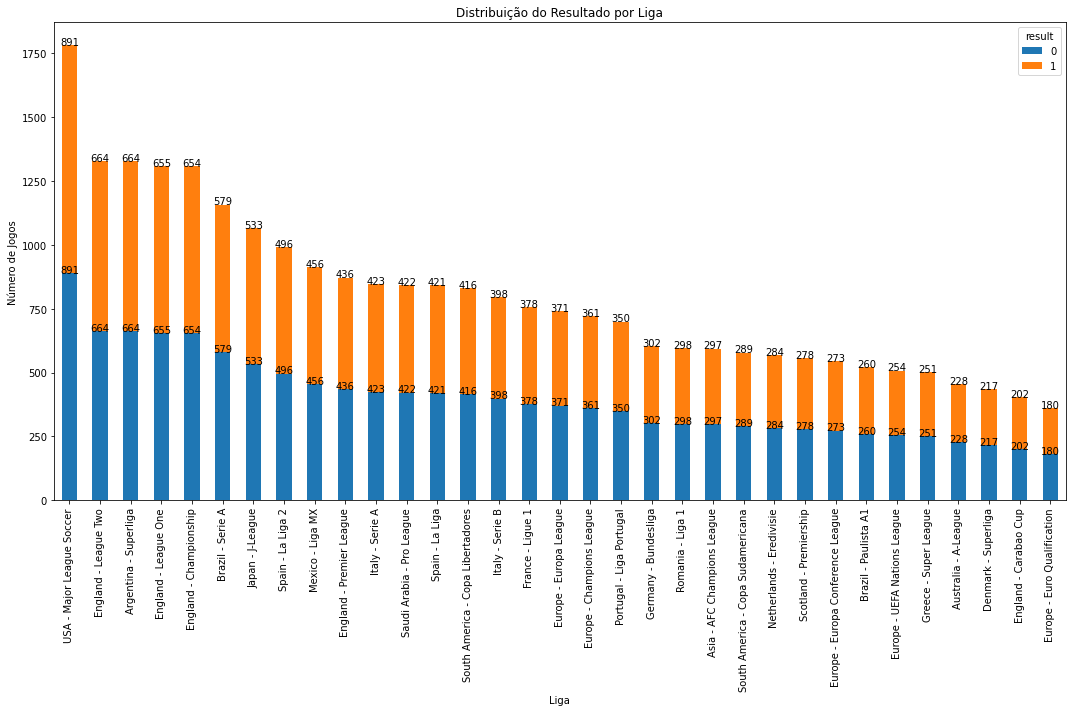

<Figure size 432x288 with 0 Axes>

In [105]:
# Função para filtrar ligas com base no número mínimo de partidas
def filter_leagues(df, league_col, matches, min_matches=100):
    # Agrupa o DataFrame por liga e conta o número único de partidas para cada liga
    league_game_counts = df.groupby(league_col)[matches].nunique()
    # Filtra para manter apenas as ligas com um número de partidas igual ou maior que min_matches
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    # Filtra o DataFrame original para incluir apenas linhas das ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

def balance_data(df, league_col='league', result_col='result'):
    leagues = df[league_col].unique()
    # Lista para armazenar os DataFrames balanceados para cada liga
    balanced_dfs = []

    # Cria uma cópia do DataFrame para não alterar a coluna 'minute' original
    df_copy = df.copy()

    # Itera sobre cada liga para balancear os dados
    for league in leagues:
        # Filtra o DataFrame para incluir apenas dados da liga atual
        league_df = df_copy[df_copy[league_col] == league]
        
        # Arredondando os minutos para o inteiro mais próximo para fins de balanceamento
        league_df['minute_rounded'] = league_df['minute'].round()

        # Selecionando os registros onde 'result' é 1
        result_1 = league_df[league_df[result_col] == 1]

        # Contando os minutos únicos arredondados e suas ocorrências em 'result' 1
        minutes_counts = result_1['minute_rounded'].value_counts()

        # Selecionando registros onde 'result' é 0 e amostrando aleatoriamente com base no número de ocorrências do mesmo minuto arredondado
        result_0_sample = pd.DataFrame()
        for minute, count in minutes_counts.items():
            # Filtra registros com 'result' 0 e o minuto arredondado correspondente
            potential_samples = league_df[(league_df['result'] == 0) & (league_df['minute_rounded'] == minute)]
            
            # Verifica se há registros suficientes para amostrar
            if potential_samples.shape[0] >= count:
                sample = potential_samples.sample(n=count, replace=True, random_state=42)
            else:
                # Se não houver registros suficientes, considera todos os registros disponíveis
                sample = potential_samples

            # Removendo a coluna 'minute_rounded' para manter o formato original de 'minute'
            sample = sample.drop(columns=['minute_rounded'])

            result_0_sample = pd.concat([result_0_sample, sample])

        # Combinando os dois conjuntos de dados para formar um novo dataframe balanceado
        balanced_dfs.append(pd.concat([result_1.drop(columns=['minute_rounded']), result_0_sample]))
    
    # Combina todos os DataFrames balanceados em um único DataFrame
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_data



print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
tota_leagues = len(df['league'].unique())
print("Total de ligas:", tota_leagues)
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")

balanced_data = balance_data(filtered_data)
# balanced_data = filtered_data.copy()

print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
tota_leagues = len(balanced_data['league'].unique())
print("Total de ligas:", tota_leagues)
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [106]:
balanced_data

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,15.53,Club Guaraní,CD San José,0.0,0.0,7.0,0.0,1.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,4.0,6.0,1,2020-01-29-Club Guaraní-CD San José,38.0,62.0
1,16.32,Club Guaraní,CD San José,0.0,0.0,7.0,0.0,1.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,4.0,6.0,1,2020-01-29-Club Guaraní-CD San José,38.0,62.0
2,22.60,Club Universitario de Deportes,Carabobo FC,0.0,0.0,6.0,1.0,1.0,0.0,South America - Copa Libertadores,...,4.0,3.0,2.0,1.0,6.0,7.0,1,2020-01-29-Club Universitario de Deportes-Cara...,55.0,45.0
3,23.24,Club Universitario de Deportes,Carabobo FC,0.0,0.0,6.0,1.0,1.0,0.0,South America - Copa Libertadores,...,5.0,3.0,2.0,1.0,6.0,8.0,1,2020-01-29-Club Universitario de Deportes-Cara...,55.0,45.0
4,11.60,Barcelona SC,CA Progreso,0.0,0.0,1.0,1.0,0.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,0.0,4.0,1,2020-01-30-Barcelona SC-CA Progreso,49.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26357,41.11,Switzerland,Andorra,0.0,0.0,5.0,0.0,1.0,0.0,Europe - Euro Qualification,...,3.0,1.0,3.0,0.0,3.0,6.0,0,2023-09-12-Switzerland-Andorra,16.0,84.0
26358,43.41,Belarus,Romania,0.0,0.0,3.0,9.0,0.0,1.0,Europe - Euro Qualification,...,5.0,7.0,1.0,1.0,7.0,3.0,0,2023-10-12-Belarus-Romania,67.0,33.0
26359,44.20,Belarus,Romania,0.0,0.0,3.0,9.0,0.0,1.0,Europe - Euro Qualification,...,5.0,7.0,1.0,1.0,7.0,4.0,0,2023-10-12-Belarus-Romania,67.0,33.0
26360,30.59,Switzerland,Andorra,0.0,0.0,4.0,0.0,1.0,0.0,Europe - Euro Qualification,...,2.0,1.0,2.0,0.0,2.0,5.0,0,2023-09-12-Switzerland-Andorra,13.0,87.0


In [107]:
# Ordenando o DataFrame
df.sort_values(by=['match_id', 'minute'], inplace=True)

In [108]:
balanced_data.reset_index(drop=True, inplace=True)
balanced_data.to_csv("data_balanced.csv", index=False, encoding='utf-8')

In [109]:
balanced_data.value_counts('result')

result
0    13181
1    13181
Name: count, dtype: int64

In [110]:
balanced_data

,minute,homeTeam,awayTeam,goalHome,goalAway,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,...,fouls_home,fouls_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id,possessiontime_away,possessiontime_home
0,15.53,Club Guaraní,CD San José,0.0,0.0,7.0,0.0,1.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,4.0,6.0,1,2020-01-29-Club Guaraní-CD San José,38.0,62.0
1,16.32,Club Guaraní,CD San José,0.0,0.0,7.0,0.0,1.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,4.0,6.0,1,2020-01-29-Club Guaraní-CD San José,38.0,62.0
2,22.60,Club Universitario de Deportes,Carabobo FC,0.0,0.0,6.0,1.0,1.0,0.0,South America - Copa Libertadores,...,4.0,3.0,2.0,1.0,6.0,7.0,1,2020-01-29-Club Universitario de Deportes-Cara...,55.0,45.0
3,23.24,Club Universitario de Deportes,Carabobo FC,0.0,0.0,6.0,1.0,1.0,0.0,South America - Copa Libertadores,...,5.0,3.0,2.0,1.0,6.0,8.0,1,2020-01-29-Club Universitario de Deportes-Cara...,55.0,45.0
4,11.60,Barcelona SC,CA Progreso,0.0,0.0,1.0,1.0,0.0,0.0,South America - Copa Libertadores,...,1.0,3.0,0.0,0.0,0.0,4.0,1,2020-01-30-Barcelona SC-CA Progreso,49.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26357,41.11,Switzerland,Andorra,0.0,0.0,5.0,0.0,1.0,0.0,Europe - Euro Qualification,...,3.0,1.0,3.0,0.0,3.0,6.0,0,2023-09-12-Switzerland-Andorra,16.0,84.0
26358,43.41,Belarus,Romania,0.0,0.0,3.0,9.0,0.0,1.0,Europe - Euro Qualification,...,5.0,7.0,1.0,1.0,7.0,3.0,0,2023-10-12-Belarus-Romania,67.0,33.0
26359,44.20,Belarus,Romania,0.0,0.0,3.0,9.0,0.0,1.0,Europe - Euro Qualification,...,5.0,7.0,1.0,1.0,7.0,4.0,0,2023-10-12-Belarus-Romania,67.0,33.0
26360,30.59,Switzerland,Andorra,0.0,0.0,4.0,0.0,1.0,0.0,Europe - Euro Qualification,...,2.0,1.0,2.0,0.0,2.0,5.0,0,2023-09-12-Switzerland-Andorra,13.0,87.0
